# Third attempt at building a RISE explainer for embedded spaces

In the second notebook we tried to refactor our promising results from the first notebook, but unfortunately the results seem to be worse now and lack the consistency that they still had in the first notebook. We need to find out why that is. We will try with more masks.

At the same time, we will try things out on a different set of images:
1. an image that contains two different imagenet-classifiable objects
2. an image of one of those type of objects only
3. an image of the other of those two objects.

This should make it easier for the explainer to highlight which parts of the first image bring it closer to the second or third. This way we exclude explainability issues from our debugging attempts.

## Left over todos from the previous notebook:

In the previous notebook we built a first attempt using two labra doodles. We had some success, but still need:
1. more understanding of the output and
2. need to run on several examples to get a feeling of the robustness of the method and
3. also to assess its performance on very different images (since we focused on very similar images before).

We also at some point will look into multimodal models, but this will require changing the API to input two models. This we will do in a next step, after we understand the basics better.

Image combinations to try out here:
- Bee vs fly (similar in insectiness but also differences)
- Flower vs car
- Car vs bike
- Image with both "cat and labradoodle" vs cat and vs labradoodle.

We need to take care with backgrounds that could be distinguishing, probably keep them similar when trying to focus on the actual objects? Or not, but in any case, let's be aware.

In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from tensorflow.keras import backend as K
from skimage.transform import resize
from requests import get
import os
from urllib.parse import urlparse
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K


class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)


def load_img(path, target_size):
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


def generate_masks(N, s, p1, model_input_size):
    cell_size = np.ceil(np.array(model_input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model_input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model_input_size[0], y:y + model_input_size[1]]
    masks = masks.reshape(-1, *model_input_size, 1)
    return masks


def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]


def download(url):
    filename = os.path.basename(urlparse(url).path)
    os.system(f"wget {url}")
    return filename


def plot_explainer(image, saliency, ax=None, vmin=None, vmax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()
    ax.set_title('Explanation')
    ax.axis('off')
    ax.imshow(image)
    im = ax.imshow(saliency, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax)
    return fig


# from https://stackoverflow.com/a/52897216/1199693
def set_all_the_seeds(seed_value=0):
    os.environ['PYTHONHASHSEED']=str(seed_value)

    random.seed(seed_value)

    np.random.seed(seed_value)

    tf.random.set_seed(seed_value)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# import importlib
# importlib.reload(embeddings)

In [5]:
model = Model()

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


102981632/102967424 [==============================] - 1s 0us/step


In [10]:
urls = ['https://get.pxhere.com/photo/asphalt-car-daylight-dog-dog-collar-land-rover-lying-model-outdoors-pavement-pet-pitbull-range-rover-road-street-suv-travel-vehicle-wheel-1553095.jpg',
        'https://c.pxhere.com/photos/02/85/boxer_dog_boxer_dog_cute_young_puppy_canine_pet-1023459.jpg!s',
        'https://c4.wallpaperflare.com/wallpaper/680/516/923/the-sky-the-city-coupe-panorama-wallpaper-preview.jpg']
filenames = [download(url) for url in urls]

img_dogcar, x_dogcar = load_img(filenames[0], model.input_size)
img_dog, x_dog = load_img(filenames[1], model.input_size)
img_car, x_car = load_img(filenames[2], model.input_size)

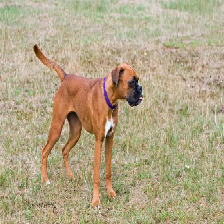

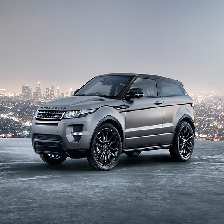

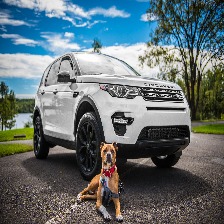

(None, None, None)

In [11]:
display(img_dog), display(img_car), display(img_dogcar)

In [12]:
def get_masked_predictions(model, inp, masks, batch_size=10):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    N = len(masks)
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    return preds

def explain(model, inp, reference_inp, masks, batch_size=10, preds=None):
    if preds is None:
        preds = get_masked_predictions(model, inp, masks, batch_size=batch_size)

    reference_pred = model.run_on_batch(reference_inp)
    distances = pairwise_distances(preds, reference_pred, metric='cosine') / 2
    mask_weights = np.exp(-distances)
    print('weights.shape', mask_weights.shape)

    sal = mask_weights.T.dot(masks.reshape(len(masks), -1)).reshape(-1, *model.input_size)

    normalization = mask_weights.sum()

    sal = sal / normalization
    return sal

Explaining: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s]


weights.shape (5000, 1)


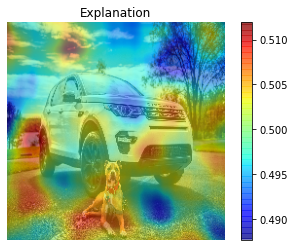

In [14]:
set_all_the_seeds(3)
_masks = generate_masks(5000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions)
_fig = plot_explainer(img_dogcar, _sal[0])

Explaining: 100%|██████████| 500/500 [01:32<00:00,  5.43it/s]


weights.shape (5000, 1)


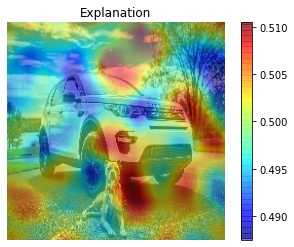

In [16]:
set_all_the_seeds(33)
_masks = generate_masks(5000, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions)
_fig = plot_explainer(img_dogcar, _sal[0])

Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


weights.shape (10, 1)


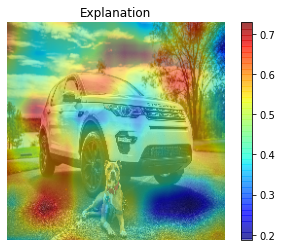

In [17]:
set_all_the_seeds(33)
_masks = generate_masks(10, 8, 0.5, model.input_size)
_masked_predictions = get_masked_predictions(model, x_dogcar, _masks)
_sal = explain(model, x_dogcar, x_dog, _masks, preds=_masked_predictions)
_fig = plot_explainer(img_dogcar, _sal[0])

In [21]:
np.sqrt(10/5000)

0.044721359549995794

In [22]:
0.02/0.5

0.04

I think these ranges show that we are seeing pure sampling noise which goes with the inverse square root of the number of samples.